## Week5 Advanced Homework

In [4]:
#!pip install langchain-community langchain-openai langgraph

In [1]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain


from langchain.text_splitter import CharacterTextSplitter
#from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain.document_loaders import PyPDFLoader
#from langchain.document_loaders import UnstructuredFileLoader

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv('OPENAI_API_KEY')

## [MY CODE] 논문 로드

In [5]:
loader = PyPDFLoader(
    file_path= 'RAG_paper.pdf',
)
docs = loader.load()
print('논문 페이지 수:', len(docs))

논문 페이지 수: 19


In [6]:
docs[0]

Document(metadata={'source': 'RAG_paper.pdf', 'page': 0}, page_content='Retrieval-Augmented Generation for\nKnowledge-Intensive NLP Tasks\nPatrick Lewis†‡, Ethan Perez⋆,\nAleksandra Piktus†, Fabio Petroni†, Vladimir Karpukhin†, Naman Goyal†, Heinrich Küttler†,\nMike Lewis†, Wen-tau Yih†, Tim Rocktäschel†‡, Sebastian Riedel†‡, Douwe Kiela†\n†Facebook AI Research; ‡University College London; ⋆New York University;\nplewis@fb.com\nAbstract\nLarge pre-trained language models have been shown to store factual knowledge\nin their parameters, and achieve state-of-the-art results when ﬁne-tuned on down-\nstream NLP tasks. However, their ability to access and precisely manipulate knowl-\nedge is still limited, and hence on knowledge-intensive tasks, their performance\nlags behind task-speciﬁc architectures. Additionally, providing provenance for their\ndecisions and updating their world knowledge remain open research problems. Pre-\ntrained models with a differentiable access mechanism to explici

In [7]:
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    separator="\n",  
    chunk_size=3000, 
    chunk_overlap=500,
)

split_docs = text_splitter.split_documents(docs)

print('분할 수:', len(split_docs))

분할 수: 19


In [8]:
split_docs[0]

Document(metadata={'source': 'RAG_paper.pdf', 'page': 0}, page_content='Retrieval-Augmented Generation for\nKnowledge-Intensive NLP Tasks\nPatrick Lewis†‡, Ethan Perez⋆,\nAleksandra Piktus†, Fabio Petroni†, Vladimir Karpukhin†, Naman Goyal†, Heinrich Küttler†,\nMike Lewis†, Wen-tau Yih†, Tim Rocktäschel†‡, Sebastian Riedel†‡, Douwe Kiela†\n†Facebook AI Research; ‡University College London; ⋆New York University;\nplewis@fb.com\nAbstract\nLarge pre-trained language models have been shown to store factual knowledge\nin their parameters, and achieve state-of-the-art results when ﬁne-tuned on down-\nstream NLP tasks. However, their ability to access and precisely manipulate knowl-\nedge is still limited, and hence on knowledge-intensive tasks, their performance\nlags behind task-speciﬁc architectures. Additionally, providing provenance for their\ndecisions and updating their world knowledge remain open research problems. Pre-\ntrained models with a differentiable access mechanism to explici

## [LOG] page별로 문서를 로드하고 split

## [MY CODE] MapReduce로 논문 요약 구현 (old version - LLMChain)

In [ ]:
# Map에 사용할 prompt template
map_template = """다음은 문서 중 일부 내용입니다
{pages}
이 문서 목록을 기반으로 주요 내용을 요약해 주세요.
답변: """

# Map 프롬프트
map_prompt = PromptTemplate.from_template(map_template)

# Map에서 수행할 LLMChain 정의
llm = ChatOpenAI(temperature=0, 
                 model_name='gpt-4o-mini',
                 api_key=api_key)
map_chain = LLMChain(llm=llm, prompt=map_prompt)

/var/folders/gj/86sxmqd95yd0hskfrsflrx480000gp/T/ipykernel_95985/4193787190.py:18: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  map_chain = LLMChain(llm=llm, prompt=map_prompt)


In [7]:
# Reduce에 사용할 prompt template
reduce_template = """다음은 요약의 집합입니다:
{doc_summaries}
이것으로 통합된 요약을 만들어 주세요.
답변: """

# Reduce 프롬프트
reduce_prompt = PromptTemplate.from_template(reduce_template)

# Reduce에서 수행할 LLMChain 정의
reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)

In [8]:
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains import ReduceDocumentsChain

# 문서의 목록을 받아들여, 이를 단일 문자열로 결합하고, 이를 LLMChain에 전달
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain,                
    document_variable_name="doc_summaries"
)

# Map 문서를 통합하고 순차적으로 Reduce합니다.
reduce_documents_chain = ReduceDocumentsChain(
    combine_documents_chain=combine_documents_chain,    # 호출되는 최종 체인입니다.
    collapse_documents_chain=combine_documents_chain,   # 문서가 `StuffDocumentsChain`의 컨텍스트를 초과하는 경우
    token_max=4000,                                     # 문서를 그룹화할 때의 토큰 최대 개수입니다.
)

/var/folders/gj/86sxmqd95yd0hskfrsflrx480000gp/T/ipykernel_95985/4154098370.py:5: LangChainDeprecationWarning: This class is deprecated. Use the `create_stuff_documents_chain` constructor instead. See migration guide here: https://python.langchain.com/docs/versions/migrating_chains/stuff_docs_chain/
  combine_documents_chain = StuffDocumentsChain(
/var/folders/gj/86sxmqd95yd0hskfrsflrx480000gp/T/ipykernel_95985/4154098370.py:11: LangChainDeprecationWarning: This class is deprecated. Please see the migration guide here for a recommended replacement: https://python.langchain.com/docs/versions/migrating_chains/map_reduce_chain/
  reduce_documents_chain = ReduceDocumentsChain(


In [9]:
from langchain.chains import MapReduceDocumentsChain

# 문서들에 체인을 매핑하여 결합하고, 그 다음 결과들을 결합합니다.
map_reduce_chain = MapReduceDocumentsChain(
    llm_chain=map_chain,
    reduce_documents_chain=reduce_documents_chain,
    document_variable_name="pages",
    return_intermediate_steps=False,
)

/var/folders/gj/86sxmqd95yd0hskfrsflrx480000gp/T/ipykernel_95985/2103415951.py:4: LangChainDeprecationWarning: This class is deprecated. Please see the migration guide here for a recommended replacement: https://python.langchain.com/docs/versions/migrating_chains/map_reduce_chain/
  map_reduce_chain = MapReduceDocumentsChain(


In [10]:
# Map-Reduce chain
result = map_reduce_chain.run(split_docs)

/var/folders/gj/86sxmqd95yd0hskfrsflrx480000gp/T/ipykernel_95985/3595548341.py:3: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = map_reduce_chain.run(split_docs)


In [11]:
# 요약결과 출력
print(result)

이 문서는 Retrieval-Augmented Generation (RAG) 모델에 대한 포괄적인 연구를 다루고 있으며, 이 모델은 사전 훈련된 검색기와 시퀀스-투-시퀀스(seq2seq) 생성 모델을 결합하여 지식 집약적인 자연어 처리(NLP) 작업을 수행하는 데 중점을 두고 있습니다. 주요 내용은 다음과 같습니다:

1. **모델 구조 및 하이브리드 메모리**: RAG 모델은 입력 쿼리에 대해 관련 문서를 검색하는 검색기와 검색된 문서를 기반으로 텍스트를 생성하는 생성기로 구성됩니다. 이 모델은 파라메트릭 메모리(사전 훈련된 seq2seq 모델)와 비파라메트릭 메모리(밀집 벡터 인덱스)를 결합하여 외부 지식 소스에 접근할 수 있도록 합니다.

2. **성능 평가**: RAG 모델은 Natural Questions, WebQuestions, CuratedTrec와 같은 데이터셋에서 최첨단 성능을 달성하였으며, Jeopardy 질문 생성 및 FEVER 사실 검증 작업에서도 우수한 결과를 보였습니다. RAG는 BART 모델과 비교하여 더 사실적이고 구체적인 응답을 생성하는 경향이 있습니다.

3. **디코딩 방법**: RAG 모델은 RAG-Sequence와 RAG-Token 두 가지 방식으로 디코딩을 수행합니다. RAG-Sequence는 동일한 검색된 문서를 사용하여 전체 시퀀스를 생성하는 반면, RAG-Token은 각 타겟 토큰에 대해 다른 문서를 선택할 수 있습니다.

4. **지식 업데이트**: 비파라메트릭 메모리는 세계의 변화에 따라 모델의 지식을 업데이트하는 데 사용될 수 있으며, 이는 RAG 모델의 유연성을 높입니다.

5. **구현 세부사항 및 훈련 설정**: RAG 모델은 Open-domain QA에서 15개 또는 50개의 문서를 사용하여 테스트되며, Fairseq를 통해 훈련됩니다. 훈련 과정에서 8개의 32GB NVIDIA V100 GPU를 활용하며, 코드가 HuggingFace Transformers로 포팅되어 오픈 소스로 제공됩니다.

6. 

## [LOG] 순서를 매겨서 잘 요약하였음

## [MY CODE] MapReduce 방법으로 논문 요약 (new version - Runnable)

In [8]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [9]:
# get llm
llm = ChatOpenAI(temperature=0, 
                 model_name='gpt-4o-mini',
                 api_key=api_key)

In [10]:
# Map에 사용할 prompt template
map_template = """다음은 문서 중 일부 내용입니다
{pages}
이 문서 목록을 기반으로 주요 내용을 요약해 주세요.
답변:"""

# Map 프롬프트
map_prompt = ChatPromptTemplate([("human", map_template)])

# Runnable 형식 사용
map_chain = map_prompt | llm | StrOutputParser()

In [11]:
# Reduce에 사용할 prompt template
reduce_template = """다음은 요약의 집합입니다:
{doc_summaries}
이것으로 통합된 요약을 만들어 주세요.
답변:"""

# Reduce 프롬프트
reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

# Runnable 형식 사용
reduce_chain = reduce_prompt | llm | StrOutputParser()

In [12]:
import operator
from typing import Annotated, List, TypedDict

from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    response = await map_chain.ainvoke(state["content"])
    return {"summaries": [response]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state["summaries"])
    return {"final_summary": response}

In [20]:
# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)
graph.add_node("generate_final_summary", generate_final_summary)
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "generate_final_summary")
graph.add_edge("generate_final_summary", END)
app = graph.compile()

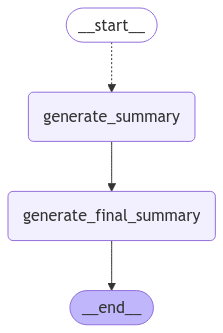

In [21]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [22]:
rsts = []
# split_docs 순서 대로 요약 시작
async for step in app.astream({"contents": [doc.page_content for doc in split_docs]}):
    rsts.append(step)
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_final_summary']


In [23]:
# 마지막 전체 요약
print(step['generate_final_summary']['final_summary'])

이 문서는 Retrieval-Augmented Generation (RAG) 모델에 대한 연구를 다루고 있으며, RAG 모델은 정보 검색과 텍스트 생성을 결합하여 지식 집약적인 자연어 처리(NLP) 작업에서 우수한 성능을 발휘하는 방법을 제안합니다. 주요 내용은 다음과 같습니다:

1. **모델 구조**: RAG 모델은 두 가지 주요 구성 요소로 이루어져 있습니다. 첫째, 입력 쿼리에 대해 관련 문서를 검색하는 검색기(DPR)와 둘째, 검색된 문서와 입력을 기반으로 텍스트를 생성하는 생성기(BART)입니다. RAG-Sequence와 RAG-Token 두 가지 형식이 있으며, 각각의 방식으로 문서를 처리합니다.

2. **하이브리드 메모리**: RAG는 파라메트릭 메모리(사전 훈련된 seq2seq 모델)와 비파라메트릭 메모리(밀집 벡터 인덱스)를 결합하여 외부 지식 소스에 접근할 수 있는 능력을 강화합니다. 이를 통해 모델은 지식을 효과적으로 활용하고 업데이트할 수 있습니다.

3. **성능 평가**: RAG 모델은 Natural Questions, WebQuestions, TriviaQA, MSMARCO 등 다양한 공개 데이터셋에서 최첨단 성능을 달성하였으며, Jeopardy 질문 생성 및 FEVER 사실 검증 작업에서도 우수한 결과를 보였습니다. RAG는 기존의 파라메트릭 모델과 비교하여 더 사실적이고 구체적인 응답을 생성하는 경향이 있습니다.

4. **훈련 및 디코딩 방법**: RAG 모델은 SGD와 Adam 옵티마이저를 사용하여 훈련되며, 검색기와 생성기를 공동으로 최적화합니다. 디코딩 방법에서는 RAG-Token과 RAG-Sequence가 서로 다른 방식으로 결과를 생성하여 성능을 극대화합니다.

5. **사회적 영향 및 위험**: RAG 모델은 Wikipedia와 같은 사실 기반 지식을 활용하여 정보의 정확성을 높이는 데 기여할 수 있지만, 외부 지식 출처의 편향과 허위 정보 생성 등의 잠재적 위험도 존재합니다. 이러한 위험을 완화하기 위한 방안도 

## [LOG] 속도와 요약내용 비교
- old version보다 속도는 빨랐음 (3분 54초 vs 26초)
- 요약 내용에 대해서는 old version이 더 자세하게 나옴

In [26]:
# split_docs (19) + final_summary (1)
len(rsts)

20

In [31]:
# 첫 splits 요약 예시
print(rsts[0]['generate_summary']['summaries'][0])

이 문서 목록은 자연어 처리(NLP) 및 인공지능(AI) 분야의 다양한 연구 결과를 포함하고 있습니다. 주요 내용을 요약하면 다음과 같습니다:

1. **독해 및 질문 응답**:
   - Christopher Clark와 Matt Gardner의 연구는 다단락 독해 이해를 위한 간단하고 효과적인 방법을 제안합니다.
   - Matthew Dunn 외의 연구는 SearchQA라는 새로운 질문 응답 데이터셋을 소개하며, 검색 엔진의 맥락을 활용합니다.
   - Angela Fan 외의 ELI5 연구는 긴 형식의 질문 응답을 다룹니다.

2. **언어 모델 및 변환기**:
   - Jacob Devlin 외의 BERT 연구는 심층 양방향 변환기를 통한 언어 이해의 사전 훈련 방법을 제시합니다.
   - Angela Fan 외의 연구는 KNN 기반의 복합 메모리로 변환기를 보강하는 방법을 탐구합니다.

3. **대화형 AI**:
   - Emily Dinan 외의 연구는 지식 기반 대화형 에이전트를 위한 "위자드 오브 위키피디아" 모델을 제안합니다.
   - Marjan Ghazvininejad 외의 연구는 지식 기반 신경 대화 모델을 개발합니다.

4. **기계 번역**:
   - Jiatao Gu 외의 연구는 검색 엔진을 활용한 신경 기계 번역 방법을 제안합니다.

5. **AI 성능 예측**:
   - Katja Grace 외의 연구는 AI가 인간 성능을 초과할 시점을 예측하기 위한 전문가 의견을 수집합니다.

이 문서들은 NLP와 AI의 최신 동향을 반영하며, 다양한 기술적 접근과 응용 사례를 통해 이 분야의 발전을 보여줍니다.


## [LOG] 문서 및 글 참조

- https://python.langchain.com/docs/versions/migrating_chains/map_reduce_chain/
- https://teddylee777.github.io/langchain/langchain-tutorial-07/